In [1]:
from citylearn import  CityLearn, building_loader, auto_size
from energy_models import HeatPump, EnergyStorage, Building
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import collections
import gym
from gym.utils import seeding

from gym import core, spaces

import os
import ptan
import time
import argparse

import model, common
from matplotlib.pyplot import figure
import numpy as np

In [2]:
class AgentD4PG(ptan.agent.BaseAgent):
    """
    Agent implementing noisy agent
    """
    def __init__(self, net, device="cpu", epsilon=1.0):
        self.net = net
        self.device = device
        self.epsilon = epsilon

    def __call__(self, states, agent_states):
        states_v = ptan.agent.float32_preprocessor(states).to(self.device)
        mu_v = self.net(states_v)
        actions = mu_v.data.cpu().numpy()
        actions += self.epsilon * np.random.normal(size=actions.shape)
        actions = np.clip(actions, -1, 1)
        return actions, agent_states
    
class DDPGActor(nn.Module):
    def __init__(self, obs_size, act_size):
        super(DDPGActor, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(obs_size, 4),
            nn.ReLU(),
            nn.Linear(4, 4),
            nn.ReLU(),
            nn.Linear(4, act_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)


class DDPGCritic(nn.Module):
    def __init__(self, obs_size, act_size):
        super(DDPGCritic, self).__init__()

        self.obs_net = nn.Sequential(
            nn.Linear(obs_size, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
        )

        self.out_net = nn.Sequential(
            nn.Linear(8 + act_size, 6),
            nn.BatchNorm1d(6),
            nn.ReLU(),
            nn.Linear(6, 1)
        )

    def forward(self, x, a):
        obs = self.obs_net(x)
        return self.out_net(torch.cat([obs, a], dim=1))

In [3]:
from pathlib import Path

data_folder = Path("data/")

demand_file = data_folder / "AustinResidential_TH.csv"
weather_file = data_folder / 'Austin_Airp_TX-hour.csv'

In [4]:
building_ids = [4, 5, 9, 16, 21, 26, 33, 36, 49, 59]

In [5]:
heat_pump, heat_tank, cooling_tank = {}, {}, {}

#Ref: Assessment of energy efficiency in electric storage water heaters (2008 Energy and Buildings)
loss_factor = 0.19/24
buildings = {}
for uid in building_ids:
    heat_pump[uid] = HeatPump(nominal_power = 9e12, eta_tech = 0.22, t_target_heating = 45, t_target_cooling = 10)
    heat_tank[uid] = EnergyStorage(capacity = 9e12, loss_coeff = loss_factor)
    cooling_tank[uid] = EnergyStorage(capacity = 9e12, loss_coeff = loss_factor)
    buildings[uid] = Building(uid, heating_storage = heat_tank[uid], cooling_storage = cooling_tank[uid], heating_device = heat_pump[uid], cooling_device = heat_pump[uid])
    buildings[uid].state_action_space(np.array([24.0, 40.0, 1.001]), np.array([1.0, 17.0, -0.001]), np.array([0.5]), np.array([-0.5]))

In [6]:
building_loader(demand_file, weather_file, buildings)

In [7]:
auto_size(buildings, t_target_heating = 45, t_target_cooling = 10)

In [8]:
env = {}
for uid in building_ids:
    env[uid] = CityLearn(demand_file, weather_file, buildings = {uid: buildings[uid]}, time_resolution = 1, simulation_period = (3500,6000))
    env[uid](uid)

In [9]:
if __name__ == "__main__":
    N_AGENTS = 2
    GAMMA = 0.99
    BATCH_SIZE = 5000
    LEARNING_RATE_ACTOR = 1e-4
    LEARNING_RATE_CRITIC = 1e-3
    REPLAY_SIZE = 5000
    REPLAY_INITIAL = 100
    TEST_ITERS = 120
    EPSILON_DECAY_LAST_FRAME = 1000
    EPSILON_START = 1.2
    EPSILON_FINAL = 0.02

    device = torch.device("cpu")

    act_net, crt_net, tgt_act_net, tgt_crt_net, agent, exp_source, buffer, act_opt, crt_opt, frame_idx = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}
    rew_last_1000, rew, track_loss_critic, track_loss_actor = {}, {}, {}, {}
#     for uid in buildings:
#         env[uid].reset()
    for uid in building_ids:
        #Create as many actor and critic nets as number of agents
        #Actor: states_agent_i -> actions_agent_i
        act_net[uid] = DDPGActor(buildings[uid].observation_spaces.shape[0], buildings[uid].action_spaces.shape[0]).to(device)

        #Critic: states_all_agents + actions_all_agents -> Q-value_agent_i [1]
        crt_net[uid] = DDPGCritic(buildings[uid].observation_spaces.shape[0], buildings[uid].action_spaces.shape[0]).to(device)

        tgt_act_net[uid] = ptan.agent.TargetNet(act_net[uid])
        tgt_crt_net[uid] = ptan.agent.TargetNet(crt_net[uid])

        agent[uid] = model.AgentD4PG(act_net[uid], device=device)
        exp_source[uid] = ptan.experience.ExperienceSourceFirstLast(env[uid], agent[uid], gamma=GAMMA, steps_count=1)
        buffer[uid] = ptan.experience.ExperienceReplayBuffer(exp_source[uid], buffer_size=REPLAY_SIZE)
        act_opt[uid] = optim.Adam(act_net[uid].parameters(), lr=LEARNING_RATE_ACTOR)
        crt_opt[uid] = optim.Adam(crt_net[uid].parameters(), lr=LEARNING_RATE_CRITIC)

        frame_idx[uid] = 0

        rew_last_1000[uid], rew[uid], track_loss_critic[uid], track_loss_actor[uid] = [], [], [], []

    batch, states_v, actions_v, rewards_v, dones_mask, last_states_v, q_v, last_act_v, q_last_v, q_ref_v, critic_loss_v, cur_actions_v, actor_loss_v = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}
    cost, price_list, buffer_reward = {},{},{}
    for uid in buildings:
        cost[uid] = []
        price_list[uid] = []
        buffer_reward[uid] = []
    while not env[building_ids[-1]]._terminal():
        if frame_idx[4]%100 == 0:
            print(frame_idx[uid])
        for uid in buildings:
#             print(env[uid].time_step)
            agent[uid].epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx[uid] / EPSILON_DECAY_LAST_FRAME)
            frame_idx[uid] += 1           
            buffer[uid].populate(1)
#             print(buffer[uid].buffer[-1])
#             print(env[uid].buildings[uid].time_step)
            
        
        price = env[uid].total_electric_consumption[-1]*3e-5 + 0.045
        price_list[uid].append(price)
        for uid in buildings:  
            buffer_reward[uid].append(buffer[uid].buffer[-1].reward)
            electricity_cost = buffer[uid].buffer[-1].reward*price
            cost[uid].append(-electricity_cost)
            buffer[uid].buffer[-1] = buffer[uid].buffer[-1]._replace(reward=electricity_cost)

        if len(buffer[uid]) < REPLAY_INITIAL:
            continue   

        for uid in buildings:
            for k in range(6):
                batch[uid] = buffer[uid].sample(BATCH_SIZE)
                states_v[uid], actions_v[uid], rewards_v[uid], dones_mask[uid], last_states_v[uid] = common.unpack_batch_ddqn(batch[uid], device) 

                # TRAIN CRITIC
                crt_opt[uid].zero_grad()
                #Obtaining Q' using critic net with parameters teta_Q'
                q_v[uid] = crt_net[uid](states_v[uid], actions_v[uid])

                #Obtaining estimated optimal actions a|teta_mu from target actor net and from s_i+1.
                last_act_v[uid] = tgt_act_net[uid].target_model(last_states_v[uid]) #<----- Actor to train Critic

                #Obtaining Q'(s_i+1, a|teta_mu) from critic net Q'
                q_last_v[uid] = tgt_crt_net[uid].target_model(last_states_v[uid], last_act_v[uid])
                q_last_v[uid][dones_mask[uid]] = 0.0

                #Q_target used to train critic net Q'
                q_ref_v[uid] = rewards_v[uid].unsqueeze(dim=-1) + q_last_v[uid] * GAMMA
                critic_loss_v[uid] = F.mse_loss(q_v[uid], q_ref_v[uid].detach())
                critic_loss_v[uid].backward()
                crt_opt[uid].step()

                # TRAIN ACTOR
                act_opt[uid].zero_grad()
                #Obtaining estimated optimal current actions a|teta_mu from actor net and from s_i
                cur_actions_v[uid] = act_net[uid](states_v[uid])

                #Actor loss = mean{ -Q_i'(s_i, a|teta_mu) }
                actor_loss_v[uid] = -crt_net[uid](states_v[uid], cur_actions_v[uid]) #<----- Critic to train Actor
                actor_loss_v[uid] = actor_loss_v[uid].mean()
                #Find gradient of the loss and backpropagate to perform the updates of teta_mu
                actor_loss_v[uid].backward()
                act_opt[uid].step()

                if frame_idx[uid] % 1 == 0:
                    tgt_act_net[uid].alpha_sync(alpha=1 - 0.1)
                    tgt_crt_net[uid].alpha_sync(alpha=1 - 0.1)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400


In [10]:
from matplotlib.pyplot import figure

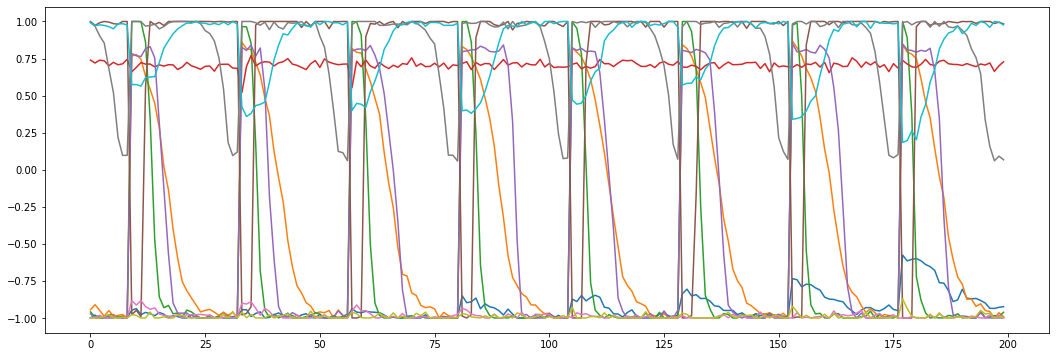

In [14]:
#Plotting all the individual actions
figure(figsize=(18, 6))
for uid in buildings:
    plt.plot(env[uid].action_track[uid][2300:2500])
plt.show()